In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt

import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


0it [00:00, ?it/s]

170500096it [00:06, 28061093.96it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'horse','ship', 'truck'}

background_classes = {'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog'}

# print(type(foreground_classes))

In [0]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)
    

In [0]:
# print(foreground_data.size())
# print(background_data.size())
# torch.save(foreground_data,'foreground_data.pt')
# torch.save(background_data,'background_data.pt')
# torch.save(foreground_label,'foreground_label.pt')
# torch.save(background_label,'background_label.pt')
# torch.load()

In [0]:
# torch.load('foreground_data.pt')
# # print(foreground_data.size())
# # print(background_data.size())

In [0]:

# foreground_data = torch.load('foreground_data.pt')
# background_data = torch.load('background_data.pt')
# foreground_label = torch.load('foreground_label.pt')
# background_label = torch.load('background_label.pt')


In [0]:
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

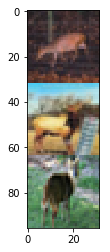

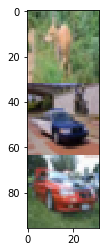

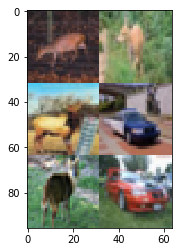

torch.Size([3, 96, 32])


In [9]:
img1 = torch.cat((background_data[0],background_data[1],background_data[2]),1)
imshow(img1)
img2 = torch.cat((background_data[27],background_data[3],background_data[43]),1)
imshow(img2)
img3 = torch.cat((img1,img2),2)
imshow(img3)
print(img2.size())


In [0]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
      label = foreground_label[fg_idx]-7  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [0]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)



4


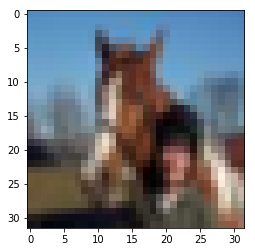

horse


In [12]:
qw=45

print(fore_idx[qw])
imshow(mosaic_list_of_images[qw][fore_idx[qw]])
# print(mosaic_list_of_images[0])
print(classes[mosaic_label[qw]+7]) # add 7 as we had subtracted 7 while saving

# imshow(mosaic_list_of_images[13][2])
# print(type(mosaic_list_of_images[1][0]))
# print(mosaic_label)

In [0]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Module1(nn.Module):
  def __init__(self):
    super(Module1, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,1)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x
      
# net = Module1()
# print(net.parameters)

In [0]:
class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    self.module1 = Module1().double()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,3)

  def forward(self,z):  #z batch of list of 9 images
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x = torch.zeros([batch,9],dtype=torch.float64)

    for i in range(9):
        x[:,i] = self.module1.forward(z[:,i])[:,0]

    x = F.softmax(x,dim=1)

    x1 = x[:,0]
    torch.mul(x1[:,None,None,None],z[:,0])

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])


    y1 = self.pool(F.relu(self.conv1(y)))
    y1 = self.pool(F.relu(self.conv2(y1)))
    y1 = y1.view(-1, 16 * 5 * 5)

    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)
    return y1 , x, y


In [0]:
fore_net = Module2().double()
# fore_net.load_state_dict(torch.load("model_epoch90.pt"))
# print(fore_net.parameters)

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)

In [0]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fore_net.parameters(), lr=0.01, momentum=0.9)
nos_epochs = 100
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

for epoch in range(nos_epochs):  # loop over the dataset multiple times

  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  
  argmax_more_than_half = 0
  argmax_less_than_half =0
  
  running_loss = 0.0
  cnt=0

  iteration = desired_num // batch
  
  #training data set
  
  for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
    # zero the parameter gradients
    
    optimizer.zero_grad()
    
    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)
#     print(outputs)
#     print(outputs.shape,labels.shape , torch.argmax(outputs, dim=1))

    loss = criterion(outputs, labels) 
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if cnt % 40 == 39:    # print every 40 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / 40))
      running_loss = 0.0
    cnt=cnt+1
    
    if epoch % 5 == 0:
      for j in range (batch):
        focus = torch.argmax(alphas[j])

        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false +=1
      
  if epoch % 5 == 0:
    col1.append(epoch)
    col2.append(argmax_more_than_half)
    col3.append(argmax_less_than_half)
    col4.append(focus_true_pred_true)
    col5.append(focus_false_pred_true)
    col6.append(focus_true_pred_false)
    col7.append(focus_false_pred_false)
  
    #************************************************************************
    #testing data set  
    with torch.no_grad():
      focus_true_pred_true =0
      focus_false_pred_true =0
      focus_true_pred_false =0
      focus_false_pred_false =0

      argmax_more_than_half = 0
      argmax_less_than_half =0
      for data in test_loader:
        inputs, labels , fore_idx = data
        outputs, alphas, avg_images = fore_net(inputs)

        _, predicted = torch.max(outputs.data, 1)

        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1
      
    col8.append(argmax_more_than_half)
    col9.append(argmax_less_than_half)
    col10.append(focus_true_pred_true)
    col11.append(focus_false_pred_true)
    col12.append(focus_true_pred_false)
    col13.append(focus_false_pred_false)
    torch.save(fore_net.state_dict(),"/content/drive/My Drive/Research/CIFAR Mosaic/weights/model_epoch"+str(epoch)+".pt")
    
print('Finished Training')
torch.save(fore_net.state_dict(),"/content/drive/My Drive/Research/CIFAR Mosaic/weights/model_epoch"+str(nos_epochs)+".pt")

[1,    40] loss: 1.099
[1,    80] loss: 1.099
[1,   120] loss: 1.099
[2,    40] loss: 1.099
[2,    80] loss: 1.099
[2,   120] loss: 1.098
[3,    40] loss: 1.098
[3,    80] loss: 1.098
[3,   120] loss: 1.098
[4,    40] loss: 1.098
[4,    80] loss: 1.098
[4,   120] loss: 1.098
[5,    40] loss: 1.098
[5,    80] loss: 1.098
[5,   120] loss: 1.097
[6,    40] loss: 1.097
[6,    80] loss: 1.096
[6,   120] loss: 1.095
[7,    40] loss: 1.094
[7,    80] loss: 1.092
[7,   120] loss: 1.090
[8,    40] loss: 1.087
[8,    80] loss: 1.081
[8,   120] loss: 1.079
[9,    40] loss: 1.076
[9,    80] loss: 1.073
[9,   120] loss: 1.075
[10,    40] loss: 1.073
[10,    80] loss: 1.069
[10,   120] loss: 1.071
[11,    40] loss: 1.067
[11,    80] loss: 1.065
[11,   120] loss: 1.068
[12,    40] loss: 1.065
[12,    80] loss: 1.065
[12,   120] loss: 1.058
[13,    40] loss: 1.061
[13,    80] loss: 1.056
[13,   120] loss: 1.058
[14,    40] loss: 1.057
[14,    80] loss: 1.059
[14,   120] loss: 1.052
[15,    40] loss: 1

In [0]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]


In [0]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [0]:
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [23]:
df_train

epochs  argmax > 0.5  ...  focus_true_pred_false  focus_false_pred_false
0        0             0  ...                   2429                   17562
1        5             0  ...                   2381                   16177
2       10             0  ...                   3109                   14195
3       15             0  ...                   3998                   12529
4       20             0  ...                   4314                   11872
5       25          3740  ...                   3626                    9908
6       30         14980  ...                   2909                    7535
7       35         19631  ...                   2205                    5541
8       40         21895  ...                   1565                    4418
9       45         23296  ...                   1235                    3517
10      50         23943  ...                    862                    2885
11      55         24892  ...                    715                    2329
12      60         25251  ...                    532                    2016
13      65         25673  ...                    418                    1566
14      70         25791  ...                    315                    1362
15      75         25746  ...                    325                    1127
16      80         25857  ...                    208                     852
17      85         26290  ...                    164                     651
18      90         26244  ...                    133                     509
19      95         26305  ...                    133                     404

[20 rows x 7 columns]

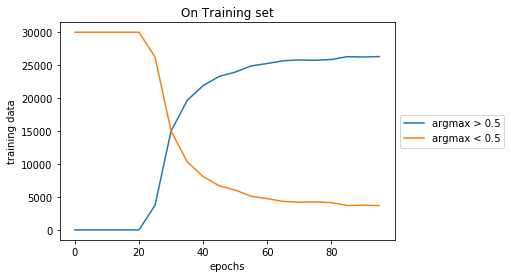

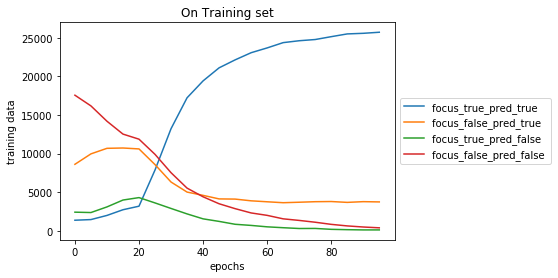

In [65]:
# plt.figure(12,12)
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.show()

plt.plot(col1,col4, label ="focus_true_pred_true ")
plt.plot(col1,col5, label ="focus_false_pred_true ")
plt.plot(col1,col6, label ="focus_true_pred_false ")
plt.plot(col1,col7, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.show()

In [24]:
df_test

epochs  argmax > 0.5  ...  focus_true_pred_false  focus_false_pred_false
0        0             0  ...                    802                    5824
1        5             0  ...                    799                    5127
2       10             0  ...                   1083                    4629
3       15             0  ...                   1320                    4092
4       20             0  ...                   1376                    3944
5       25          2647  ...                   1143                    3170
6       30          5390  ...                   1041                    2787
7       35          6199  ...                    705                    2131
8       40          7461  ...                    643                    1803
9       45          7658  ...                    503                    1569
10      50          7959  ...                    453                    1479
11      55          8229  ...                    363                    1303
12      60          8644  ...                    338                    1176
13      65          8436  ...                    304                    1117
14      70          8199  ...                    284                    1144
15      75          8322  ...                    283                    1096
16      80          8101  ...                    325                    1140
17      85          8395  ...                    253                     986
18      90          8071  ...                    311                    1018
19      95          8352  ...                    272                    1038

[20 rows x 7 columns]

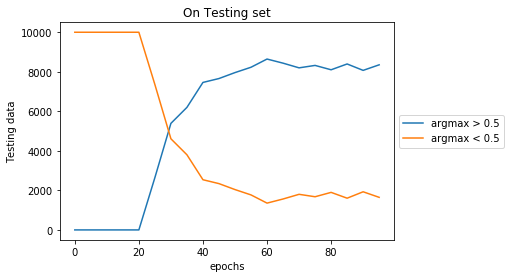

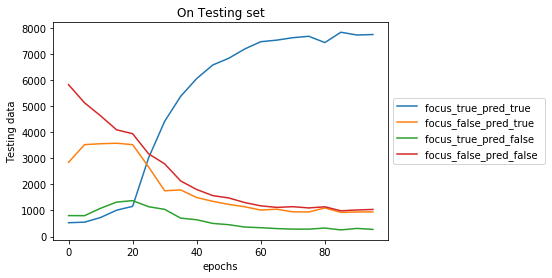

In [64]:
# plt.figure(12,12)
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.show()

plt.plot(col1,col10, label ="focus_true_pred_true ")
plt.plot(col1,col11, label ="focus_false_pred_true ")
plt.plot(col1,col12, label ="focus_true_pred_false ")
plt.plot(col1,col13, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.show()

In [66]:
print("-"*20,"Training Dataset","-"*20)
print("epochs", col1) 
print("argmax > 0.5 ", col2) 
print("argmax < 0.5 ", col3) 
print("focus_true_pred_true", col4) 
print("focus_false_pred_true", col5)
print("focus_true_pred_false", col6) 
print("focus_false_pred_false", col7) 
print("-"*20,"Testing Dataset","-"*20)
print("argmax > 0.5 ", col8)
print("argmax < 0.5", col9) 
print("focus_true_pred_true", col10) 
print("focus_false_pred_true", col11)
print("focus_true_pred_false", col12) 
print("focus_false_pred_false", col13) 

-------------------- Training Dataset --------------------
epochs [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
argmax > 0.5  [0, 0, 0, 0, 0, 3740, 14980, 19631, 21895, 23296, 23943, 24892, 25251, 25673, 25791, 25746, 25857, 26290, 26244, 26305]
argmax < 0.5  [30000, 30000, 30000, 30000, 30000, 26260, 15020, 10369, 8105, 6704, 6057, 5108, 4749, 4327, 4209, 4254, 4143, 3710, 3756, 3695]
focus_true_pred_true [1387, 1471, 2007, 2743, 3202, 7884, 13228, 17225, 19413, 21103, 22132, 23059, 23679, 24363, 24608, 24765, 25134, 25490, 25569, 25707]
focus_false_pred_true [8622, 9971, 10689, 10730, 10612, 8582, 6328, 5029, 4604, 4145, 4121, 3897, 3773, 3653, 3715, 3783, 3806, 3695, 3789, 3756]
focus_true_pred_false [2429, 2381, 3109, 3998, 4314, 3626, 2909, 2205, 1565, 1235, 862, 715, 532, 418, 315, 325, 208, 164, 133, 133]
focus_false_pred_false [17562, 16177, 14195, 12529, 11872, 9908, 7535, 5541, 4418, 3517, 2885, 2329, 2016, 1566, 1362, 1127, 852, 651, 509, 404

In [0]:
# torch.save(fore_net.state_dict(),"/content/drive/My Drive/Research/CIFAR Mosaic/weights/model_epoch"+str(nos_epochs)+"trendplot"+".pt")

In [0]:
df_train.to_csv("/content/drive/My Drive/Research/CIFAR Mosaic/focus_vs_predicted_train.csv")
df_test.to_csv("/content/drive/My Drive/Research/CIFAR Mosaic/focus_vs_predicted_test.csv")

In [0]:
def display(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

****************************************************************************************************


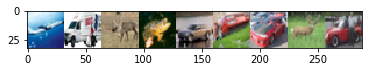

tensor([4.5587e-04, 9.8652e-01, 7.6385e-04, 6.5994e-05, 5.5322e-03, 1.1617e-03,
        2.7225e-04, 5.0679e-04, 4.7209e-03], dtype=torch.float64)


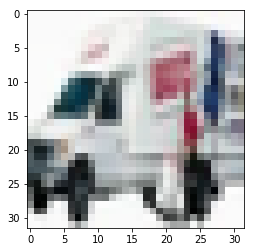

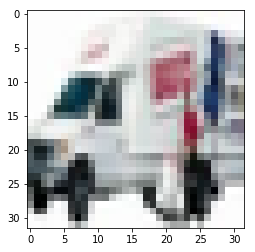

predicted truck
true truck
****************************************************************************************************


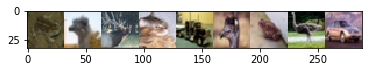

tensor([0.0305, 0.2092, 0.0125, 0.0084, 0.6825, 0.0049, 0.0212, 0.0041, 0.0267],
       dtype=torch.float64)


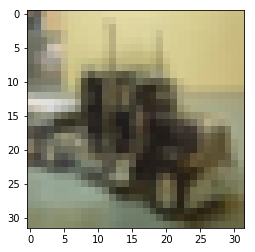

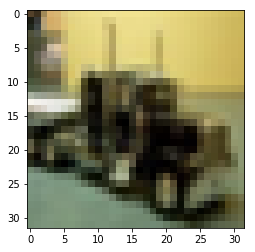

predicted truck
true truck
****************************************************************************************************


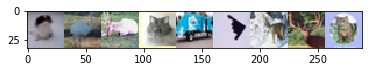

tensor([4.6267e-05, 2.1573e-03, 3.8043e-03, 2.5665e-03, 9.8789e-01, 1.1491e-04,
        4.3938e-04, 2.4151e-03, 5.6677e-04], dtype=torch.float64)


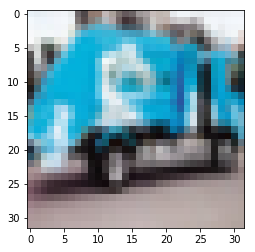

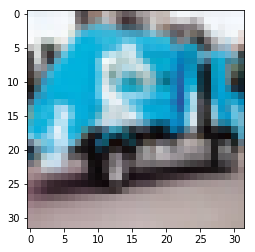

predicted truck
true truck
****************************************************************************************************


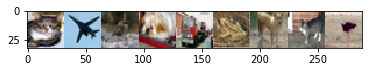

tensor([4.7670e-03, 6.3301e-04, 1.9952e-02, 1.6202e-02, 9.1270e-01, 2.7358e-03,
        2.7621e-02, 1.1929e-02, 3.4639e-03], dtype=torch.float64)


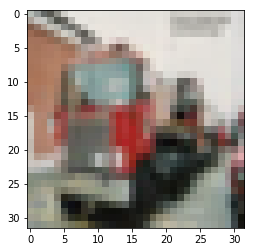

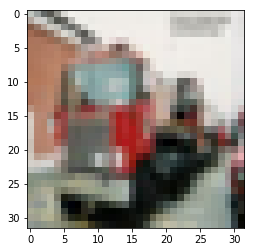

predicted truck
true truck
****************************************************************************************************


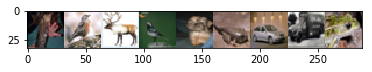

tensor([4.2849e-03, 1.2213e-03, 2.2567e-04, 8.8120e-03, 4.5101e-03, 6.3434e-03,
        6.6877e-02, 9.0756e-01, 1.6884e-04], dtype=torch.float64)


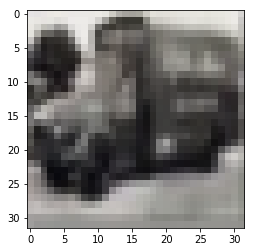

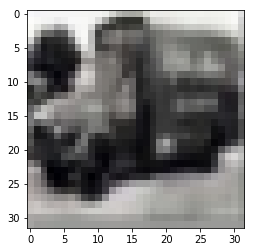

predicted truck
true truck
****************************************************************************************************


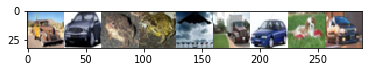

tensor([0.0559, 0.0039, 0.0041, 0.0054, 0.0046, 0.8229, 0.0020, 0.0285, 0.0727],
       dtype=torch.float64)


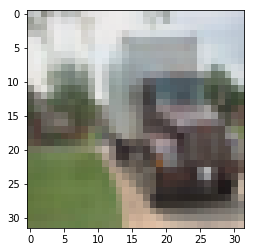

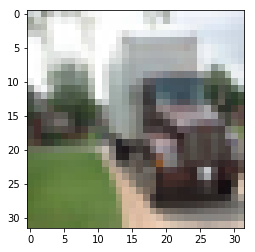

predicted truck
true truck
****************************************************************************************************


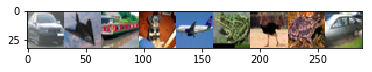

tensor([3.2592e-03, 8.4560e-03, 9.6051e-01, 2.2767e-03, 2.7328e-04, 2.4710e-03,
        1.1061e-04, 7.7453e-03, 1.4895e-02], dtype=torch.float64)


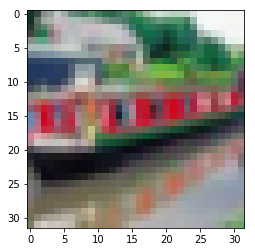

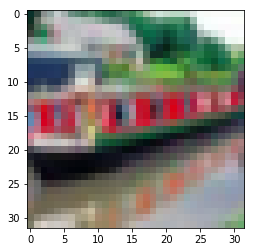

predicted ship
true ship
****************************************************************************************************


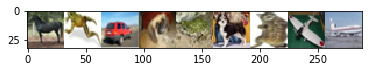

tensor([9.9834e-01, 5.0441e-06, 3.2130e-04, 1.7207e-05, 9.4841e-05, 2.2918e-05,
        1.4185e-04, 1.5333e-05, 1.0375e-03], dtype=torch.float64)


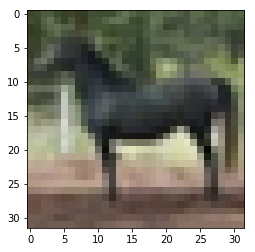

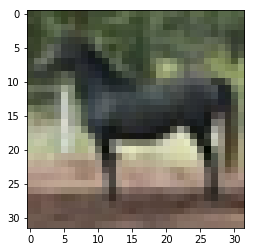

predicted horse
true horse
****************************************************************************************************


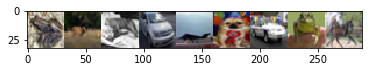

tensor([0.0421, 0.0223, 0.0097, 0.0347, 0.3450, 0.0107, 0.0091, 0.0678, 0.4586],
       dtype=torch.float64)


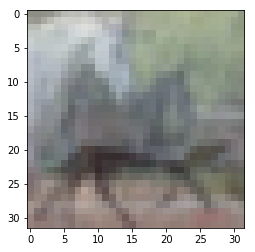

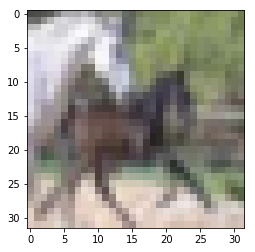

predicted horse
true horse
****************************************************************************************************


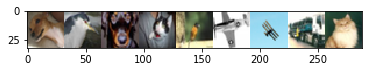

tensor([2.6888e-03, 1.2808e-03, 5.5724e-03, 1.0530e-01, 5.0140e-03, 1.0917e-02,
        4.3545e-05, 8.6898e-01, 2.0464e-04], dtype=torch.float64)


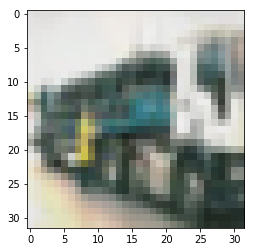

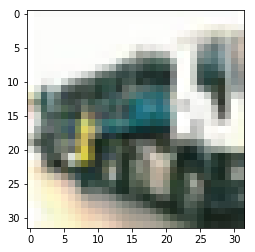

predicted truck
true truck
****************************************************************************************************


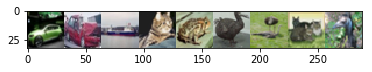

tensor([1.5825e-03, 3.3965e-03, 9.8848e-01, 1.5421e-04, 5.8728e-04, 6.4012e-04,
        5.3521e-04, 9.7039e-04, 3.6501e-03], dtype=torch.float64)


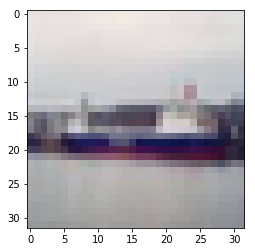

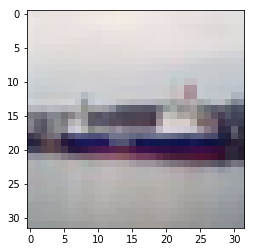

predicted ship
true ship
****************************************************************************************************


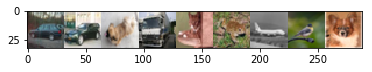

tensor([0.0035, 0.0203, 0.0058, 0.9465, 0.0114, 0.0024, 0.0080, 0.0010, 0.0011],
       dtype=torch.float64)


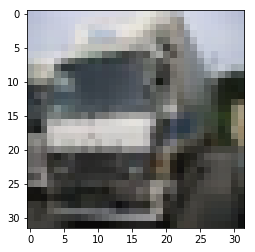

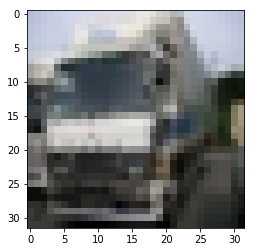

predicted truck
true truck
****************************************************************************************************


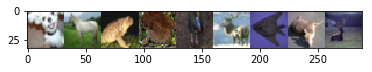

tensor([7.4160e-03, 8.8175e-01, 3.4906e-04, 1.7806e-02, 1.0988e-02, 6.1638e-03,
        2.5143e-03, 3.1547e-03, 6.9854e-02], dtype=torch.float64)


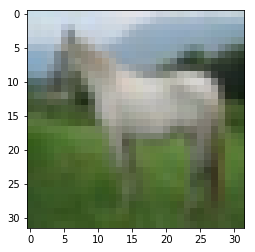

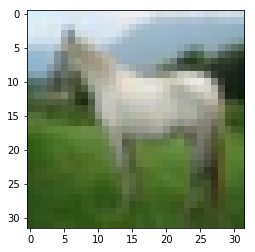

predicted horse
true horse
****************************************************************************************************


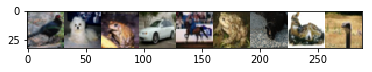

tensor([4.0862e-03, 1.8622e-03, 1.4248e-03, 8.5630e-04, 9.7531e-01, 6.9430e-04,
        1.4097e-03, 1.3168e-02, 1.1917e-03], dtype=torch.float64)


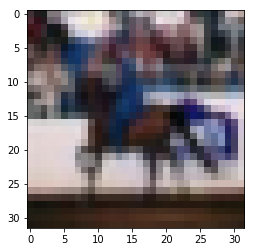

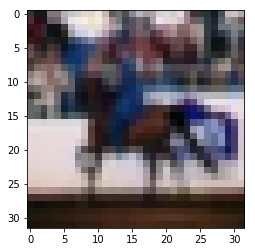

predicted horse
true horse
****************************************************************************************************


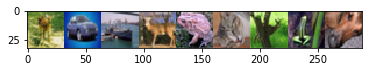

tensor([0.0098, 0.0010, 0.9130, 0.0015, 0.0050, 0.0070, 0.0064, 0.0432, 0.0131],
       dtype=torch.float64)


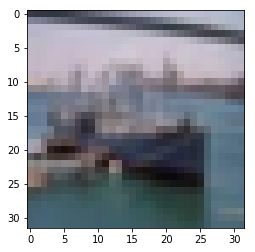

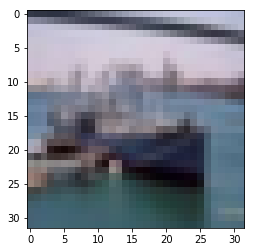

predicted ship
true ship
****************************************************************************************************


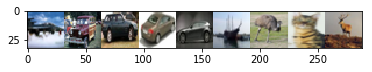

tensor([0.0108, 0.1477, 0.0153, 0.1082, 0.0713, 0.4948, 0.0430, 0.0225, 0.0865],
       dtype=torch.float64)


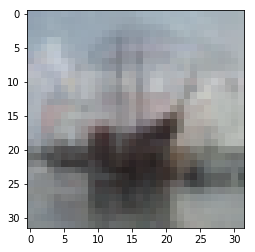

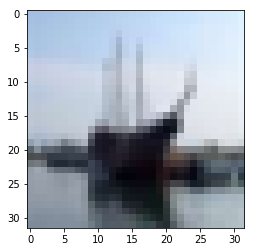

predicted ship
true ship
****************************************************************************************************


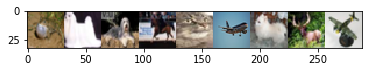

tensor([1.8236e-03, 2.6937e-03, 7.1056e-04, 9.4020e-01, 8.6933e-03, 2.2298e-04,
        4.4125e-02, 4.2195e-04, 1.1126e-03], dtype=torch.float64)


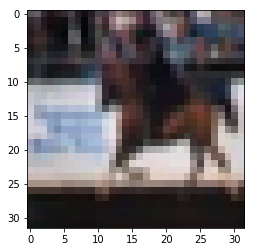

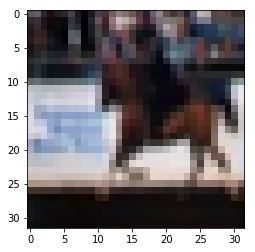

predicted horse
true horse
****************************************************************************************************


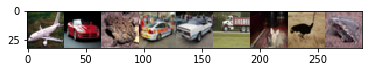

tensor([0.0012, 0.7255, 0.0756, 0.0083, 0.0011, 0.1074, 0.0587, 0.0058, 0.0164],
       dtype=torch.float64)


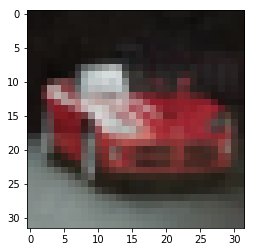

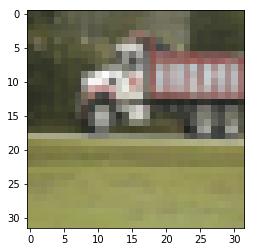

predicted truck
true truck
****************************************************************************************************


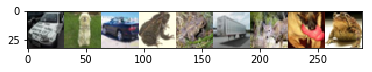

tensor([7.5981e-04, 1.1062e-04, 1.1220e-04, 9.6794e-05, 2.2992e-05, 9.9857e-01,
        1.4027e-04, 3.3113e-05, 1.5757e-04], dtype=torch.float64)


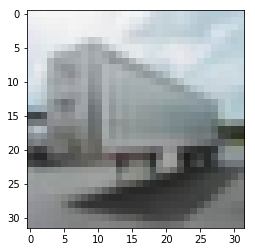

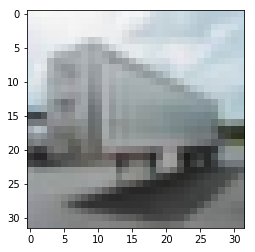

predicted truck
true truck
****************************************************************************************************


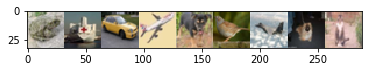

tensor([3.5500e-03, 9.8392e-01, 1.5514e-04, 1.6292e-04, 1.6179e-03, 1.5958e-05,
        9.9641e-05, 5.8189e-04, 9.8930e-03], dtype=torch.float64)


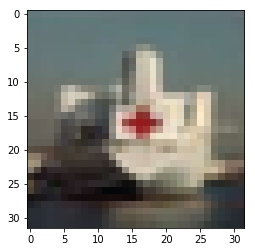

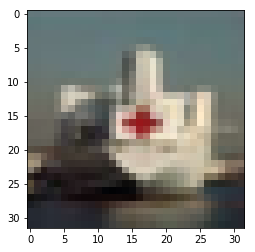

predicted ship
true ship
****************************************************************************************************


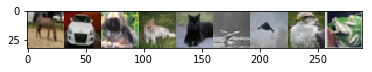

tensor([0.9294, 0.0027, 0.0054, 0.0015, 0.0020, 0.0039, 0.0012, 0.0012, 0.0527],
       dtype=torch.float64)


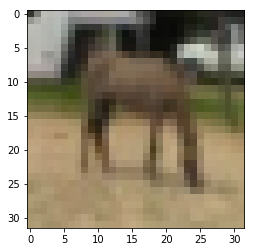

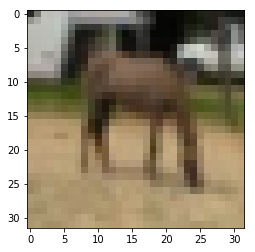

predicted horse
true horse
****************************************************************************************************


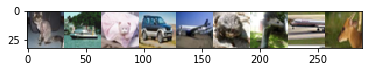

tensor([1.7726e-04, 9.6286e-01, 3.0790e-02, 3.4057e-04, 3.0745e-04, 1.0947e-03,
        1.1452e-03, 8.0969e-04, 2.4753e-03], dtype=torch.float64)


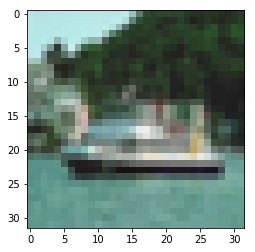

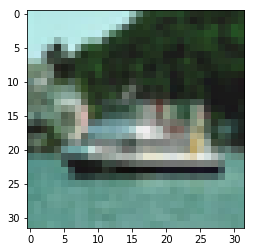

predicted ship
true ship
****************************************************************************************************


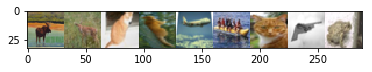

tensor([0.0061, 0.0046, 0.0014, 0.0050, 0.0691, 0.8632, 0.0172, 0.0082, 0.0251],
       dtype=torch.float64)


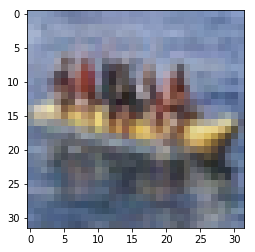

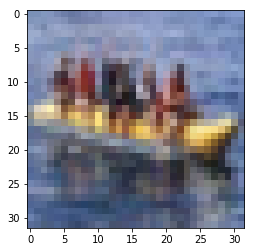

predicted ship
true ship
****************************************************************************************************


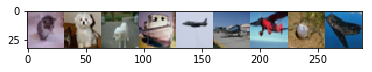

tensor([1.4213e-03, 2.1782e-04, 4.1099e-03, 9.7934e-01, 1.4003e-03, 6.0356e-03,
        1.1276e-03, 7.4471e-04, 5.6044e-03], dtype=torch.float64)


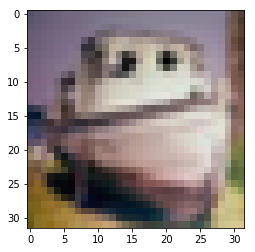

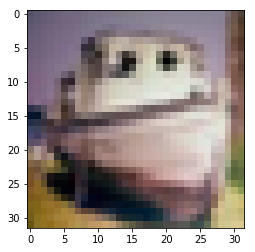

predicted ship
true ship
****************************************************************************************************


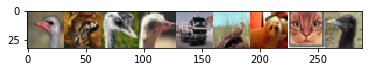

tensor([4.4936e-04, 6.3690e-03, 1.7108e-03, 2.2953e-02, 9.5220e-01, 1.0462e-02,
        3.7454e-03, 1.6697e-04, 1.9440e-03], dtype=torch.float64)


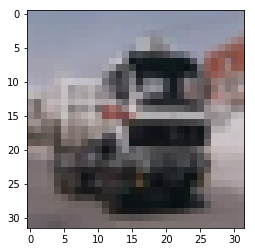

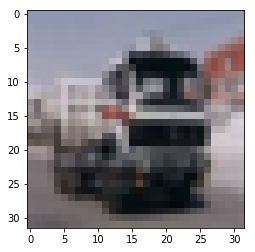

predicted truck
true truck
****************************************************************************************************


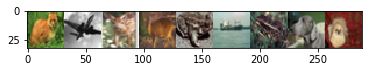

tensor([2.7847e-04, 1.0256e-03, 2.0996e-02, 1.1387e-02, 1.3414e-01, 8.1475e-01,
        5.4726e-03, 1.1221e-02, 7.2489e-04], dtype=torch.float64)


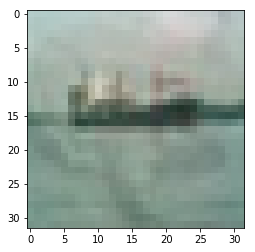

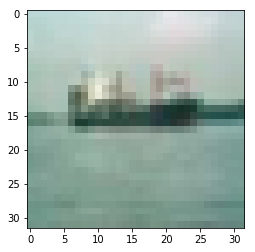

predicted ship
true ship
****************************************************************************************************


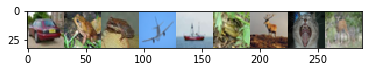

tensor([2.2145e-03, 1.7090e-04, 1.3338e-03, 2.3293e-03, 9.8275e-01, 1.4760e-03,
        6.4153e-03, 1.3636e-03, 1.9498e-03], dtype=torch.float64)


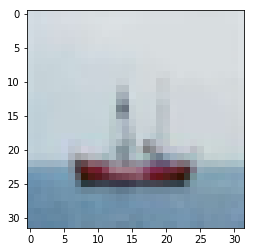

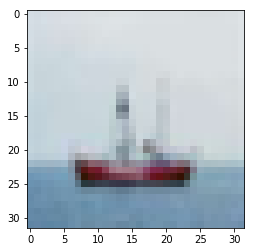

predicted ship
true ship
****************************************************************************************************


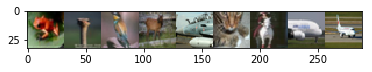

tensor([0.2129, 0.0360, 0.0261, 0.4410, 0.0648, 0.0778, 0.0122, 0.0567, 0.0726],
       dtype=torch.float64)


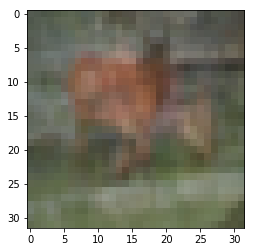

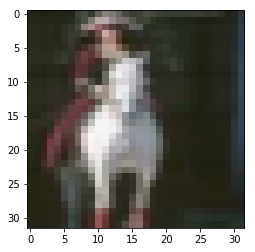

predicted horse
true horse
****************************************************************************************************


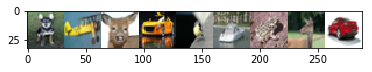

tensor([5.5222e-04, 2.5446e-03, 1.0673e-02, 1.3892e-03, 8.5684e-04, 9.7779e-01,
        5.2537e-04, 2.1326e-03, 3.5356e-03], dtype=torch.float64)


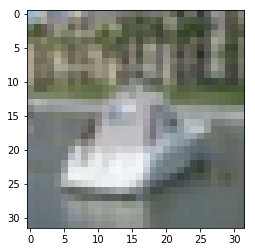

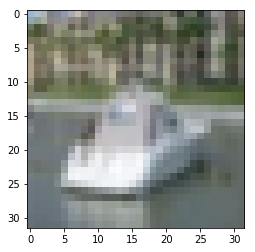

predicted ship
true ship
****************************************************************************************************


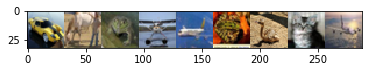

tensor([0.0397, 0.6571, 0.0281, 0.0327, 0.0498, 0.0181, 0.0616, 0.0823, 0.0304],
       dtype=torch.float64)


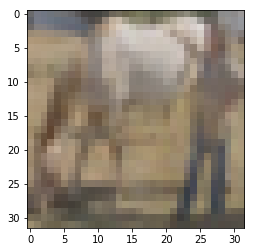

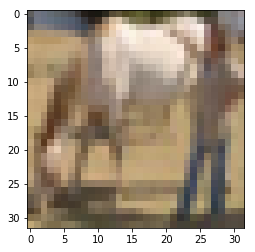

predicted horse
true horse
****************************************************************************************************


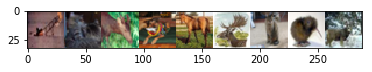

tensor([2.6929e-03, 7.3456e-03, 2.7071e-02, 1.5594e-02, 9.2573e-01, 1.8399e-03,
        1.8669e-02, 7.0981e-04, 3.5181e-04], dtype=torch.float64)


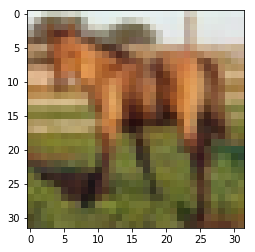

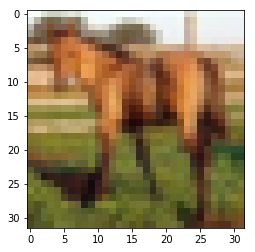

predicted horse
true horse
****************************************************************************************************


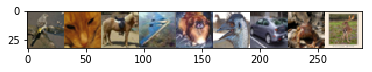

tensor([9.2109e-03, 2.8540e-03, 9.4753e-01, 7.7067e-03, 1.7913e-03, 1.7113e-03,
        8.4367e-04, 2.1616e-02, 6.7401e-03], dtype=torch.float64)


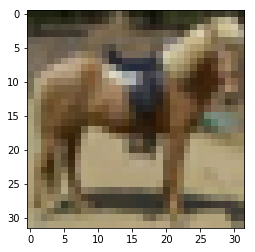

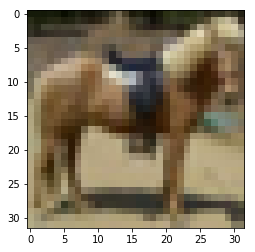

predicted horse
true horse
****************************************************************************************************


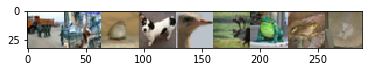

tensor([9.8157e-01, 8.6685e-03, 1.8797e-03, 2.1806e-05, 3.5146e-03, 1.1526e-03,
        1.1952e-03, 1.2204e-03, 7.7234e-04], dtype=torch.float64)


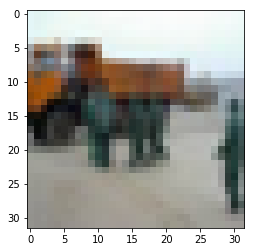

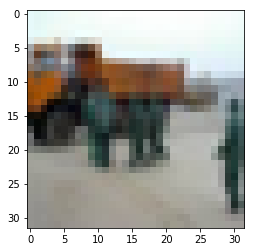

predicted truck
true truck
****************************************************************************************************


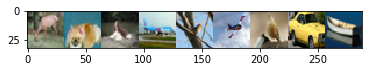

tensor([7.8073e-03, 3.7823e-02, 9.9919e-03, 3.4554e-02, 5.1066e-05, 1.0162e-04,
        2.5570e-02, 2.7796e-05, 8.8407e-01], dtype=torch.float64)


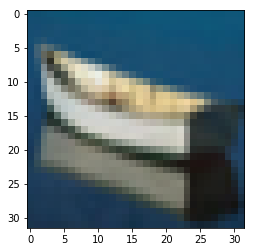

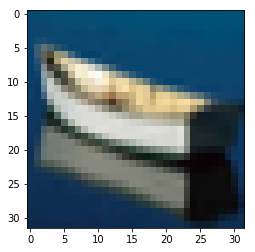

predicted ship
true ship
****************************************************************************************************


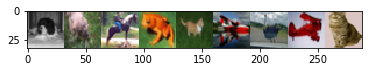

tensor([3.2694e-04, 1.9537e-03, 9.8293e-01, 9.2084e-05, 1.3536e-04, 1.6566e-03,
        1.1543e-02, 1.2076e-03, 1.5127e-04], dtype=torch.float64)


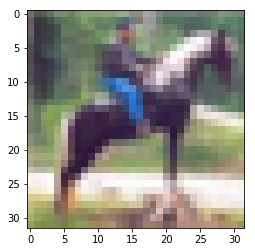

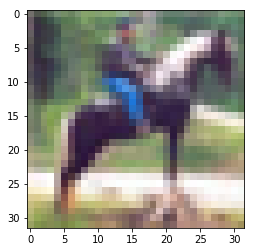

predicted horse
true horse
****************************************************************************************************


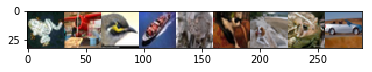

tensor([4.0392e-03, 2.1169e-02, 7.4073e-03, 9.3679e-01, 1.9742e-02, 6.3366e-04,
        3.0930e-03, 1.5061e-03, 5.6176e-03], dtype=torch.float64)


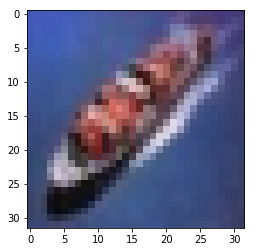

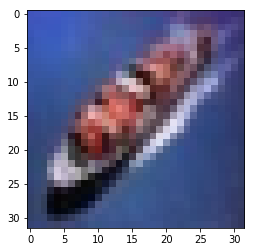

predicted ship
true ship
****************************************************************************************************


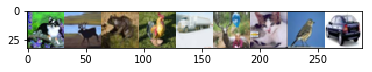

tensor([5.0837e-03, 9.3824e-01, 5.0052e-03, 2.9929e-03, 3.3339e-04, 2.0043e-02,
        2.4208e-02, 3.7333e-03, 3.5899e-04], dtype=torch.float64)


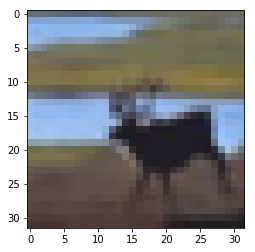

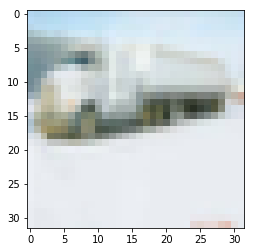

predicted truck
true truck
****************************************************************************************************


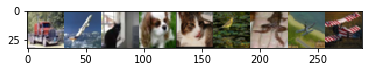

tensor([0.7380, 0.0043, 0.0257, 0.0250, 0.0410, 0.0117, 0.0174, 0.0307, 0.1060],
       dtype=torch.float64)


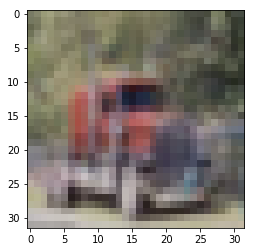

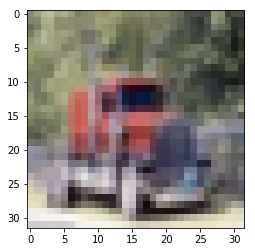

predicted truck
true truck
****************************************************************************************************


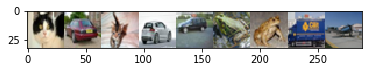

tensor([9.2540e-05, 3.6859e-03, 2.2374e-06, 4.1097e-03, 5.4528e-03, 5.5225e-03,
        4.6124e-04, 9.7588e-01, 4.7967e-03], dtype=torch.float64)


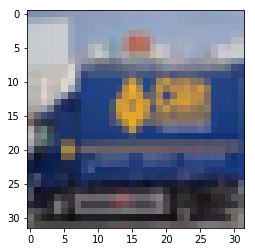

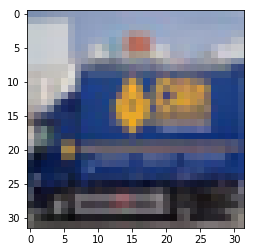

predicted truck
true truck
****************************************************************************************************


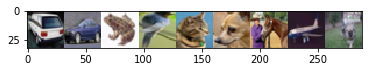

tensor([0.0680, 0.0640, 0.0040, 0.0457, 0.0834, 0.0092, 0.6268, 0.0069, 0.0919],
       dtype=torch.float64)


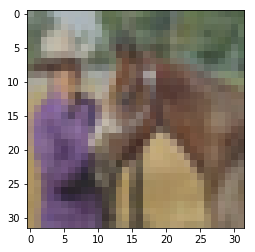

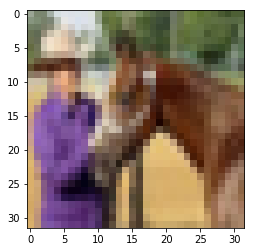

predicted horse
true horse
****************************************************************************************************


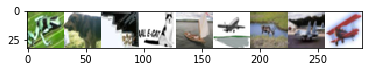

tensor([8.3296e-03, 1.2039e-02, 3.0060e-04, 1.8098e-04, 9.0569e-01, 4.6560e-02,
        3.4812e-03, 2.2519e-02, 8.9993e-04], dtype=torch.float64)


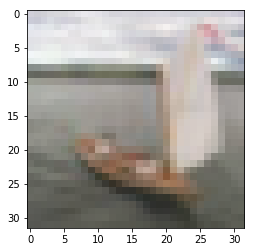

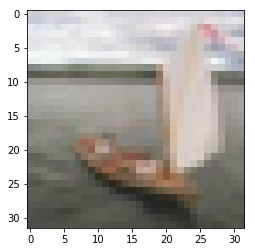

predicted ship
true ship
****************************************************************************************************


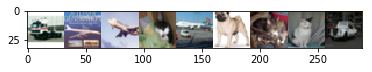

tensor([9.1891e-01, 1.3825e-02, 7.9033e-04, 1.8668e-02, 7.8442e-03, 5.3782e-04,
        7.8989e-03, 1.6476e-02, 1.5046e-02], dtype=torch.float64)


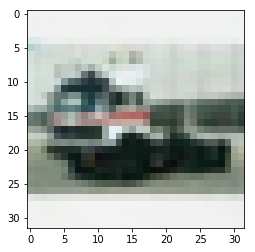

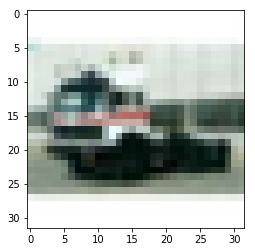

predicted truck
true truck
****************************************************************************************************


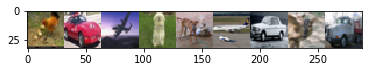

tensor([2.1178e-04, 3.0311e-04, 5.1106e-04, 1.7857e-04, 7.2564e-03, 2.9371e-04,
        1.0986e-03, 4.2866e-03, 9.8586e-01], dtype=torch.float64)


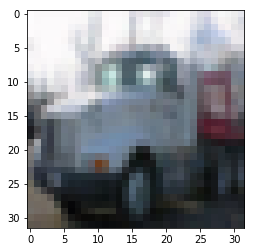

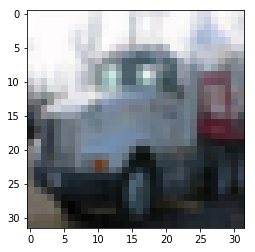

predicted truck
true truck
****************************************************************************************************


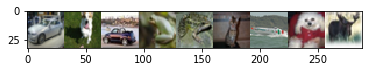

tensor([0.0024, 0.0087, 0.0983, 0.0081, 0.0023, 0.0028, 0.8729, 0.0024, 0.0022],
       dtype=torch.float64)


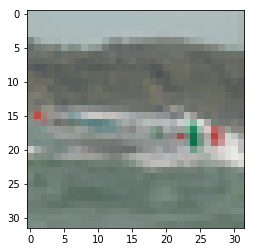

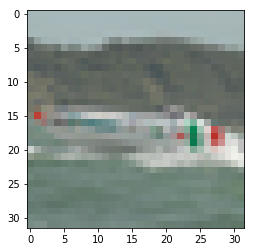

predicted ship
true ship
****************************************************************************************************


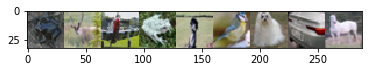

tensor([0.0177, 0.0041, 0.7231, 0.0040, 0.0087, 0.0024, 0.0031, 0.0166, 0.2202],
       dtype=torch.float64)


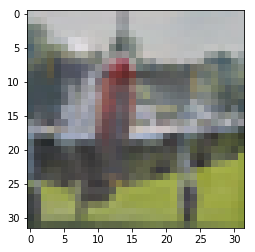

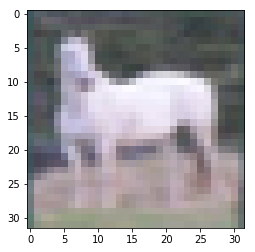

predicted horse
true horse
****************************************************************************************************


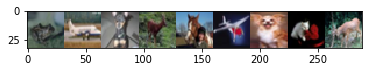

tensor([0.0949, 0.0076, 0.0871, 0.0244, 0.6657, 0.0083, 0.0102, 0.0270, 0.0748],
       dtype=torch.float64)


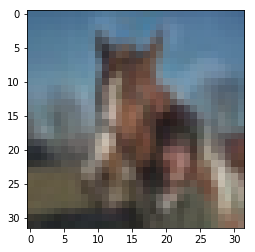

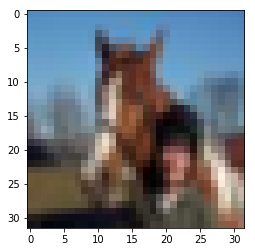

predicted horse
true horse
****************************************************************************************************


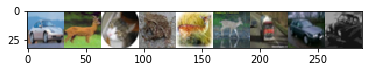

tensor([0.0083, 0.0077, 0.0047, 0.2083, 0.0432, 0.0831, 0.5358, 0.0138, 0.0951],
       dtype=torch.float64)


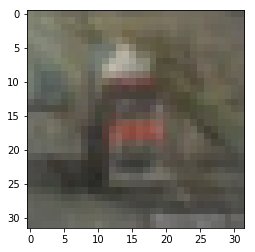

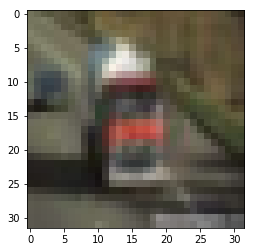

predicted truck
true truck
****************************************************************************************************


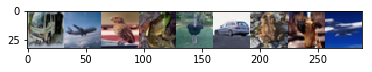

tensor([9.4220e-01, 7.6871e-05, 1.3154e-02, 3.8773e-04, 1.8739e-03, 1.1940e-02,
        8.2145e-03, 2.1964e-02, 1.8426e-04], dtype=torch.float64)


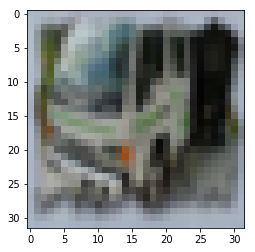

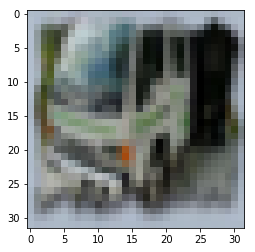

predicted truck
true truck
****************************************************************************************************


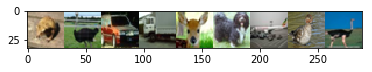

tensor([3.0436e-05, 1.0338e-04, 2.2983e-05, 9.9942e-01, 3.1298e-05, 2.1545e-04,
        1.2317e-05, 1.6069e-04, 1.2924e-06], dtype=torch.float64)


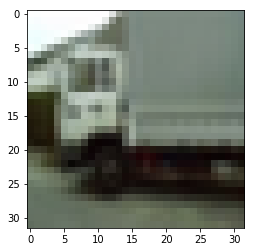

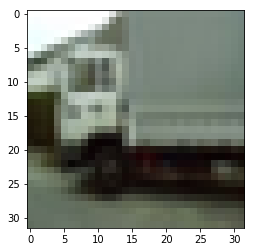

predicted truck
true truck
****************************************************************************************************


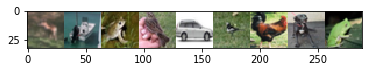

tensor([3.4929e-02, 7.6449e-01, 2.9177e-02, 3.5275e-03, 8.5750e-04, 1.1242e-02,
        5.5812e-03, 1.4963e-01, 5.7132e-04], dtype=torch.float64)


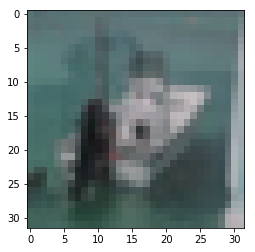

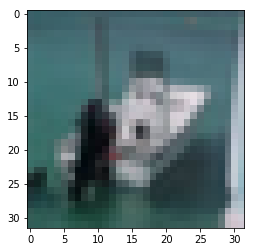

predicted ship
true ship
Accuracy of the network on the 30000 train images: 98 %
total correct 29600
total train set images 30000
focus_true_pred_true 46
focus_false_pred_true 4
focus_true_pred_false 0
focus_false_pred_false 0
argmax_more_than_half 47
argmax_less_than_half 3


In [27]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

train_loader1 = DataLoader( msd,batch_size= batch ,shuffle=False)
with torch.no_grad():
  for data in train_loader1:
    inputs, labels , fore_idx = data

    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)

    if flag==1 :
      for j in range (50):
        print("*"*100)
        img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
        display(img1)

        print(alphas[j])

        img2 = avg_images[j]
        display(img2)

        img3 = inputs[j][fore_idx[j]]
        display(img3)

        print("predicted", classes[predicted[j]+7])
        print("true", classes[labels[j]+7])
        
        focus = torch.argmax(alphas[j])
      
        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false +=1

      flag =0

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)

In [0]:
# test_data = MosaicDataset(test_images,test_label,)
# test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

0


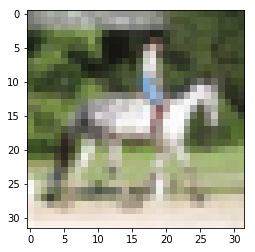

horse


In [30]:
print(fore_idx_test[0])
imshow(test_images[0][fore_idx_test[0]])
print(classes[test_label[0]+7])

****************************************************************************************************


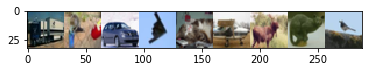

tensor([8.3303e-01, 3.2977e-03, 3.2050e-02, 2.4553e-04, 7.2639e-02, 7.0934e-03,
        1.7586e-02, 8.8252e-03, 2.5232e-02], dtype=torch.float64)


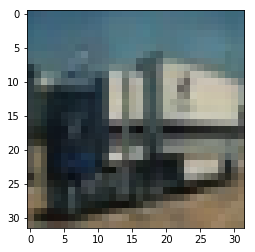

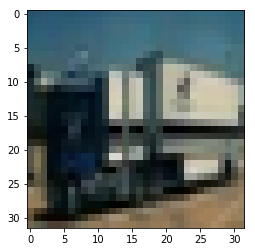

predicted truck
true truck
****************************************************************************************************


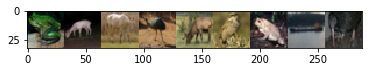

tensor([4.8638e-03, 2.6831e-04, 7.7009e-03, 7.4417e-03, 4.4539e-03, 8.2857e-04,
        8.4240e-04, 9.7318e-01, 4.1772e-04], dtype=torch.float64)


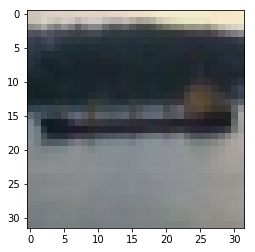

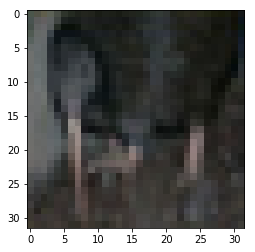

predicted ship
true ship
****************************************************************************************************


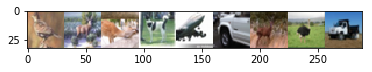

tensor([4.8449e-04, 1.2312e-02, 2.2132e-04, 1.8117e-03, 1.3922e-03, 6.0622e-04,
        2.5241e-03, 3.0144e-04, 9.8035e-01], dtype=torch.float64)


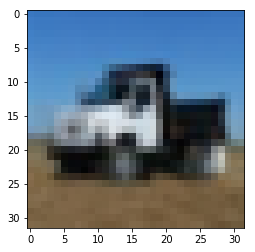

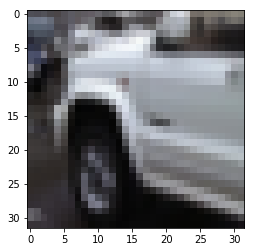

predicted truck
true truck
****************************************************************************************************


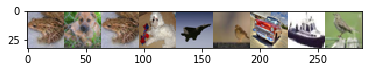

tensor([1.0798e-05, 1.2632e-05, 1.0798e-05, 1.6767e-05, 2.9384e-07, 1.6917e-05,
        2.7515e-05, 9.9990e-01, 4.7200e-06], dtype=torch.float64)


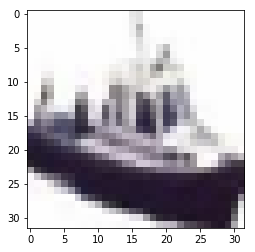

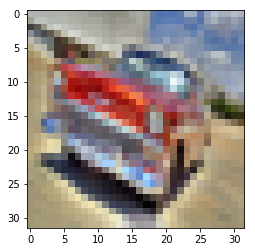

predicted ship
true ship
****************************************************************************************************


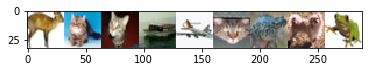

tensor([1.1997e-03, 1.9136e-02, 1.7174e-05, 9.2812e-01, 2.4770e-04, 5.4552e-03,
        3.4803e-02, 1.0903e-02, 1.1937e-04], dtype=torch.float64)


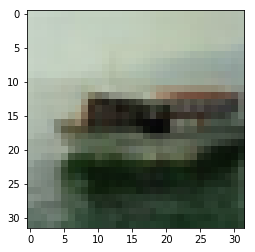

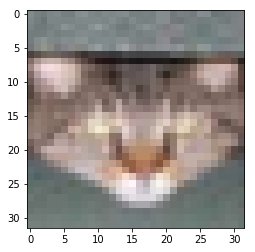

predicted ship
true ship
****************************************************************************************************


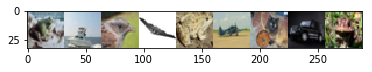

tensor([0.0175, 0.8385, 0.0190, 0.0017, 0.0047, 0.0079, 0.0095, 0.0638, 0.0374],
       dtype=torch.float64)


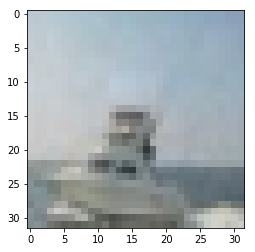

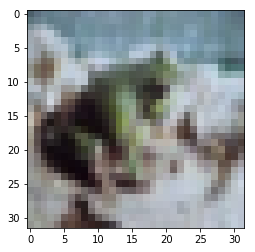

predicted ship
true ship
****************************************************************************************************


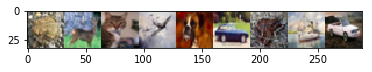

tensor([0.0399, 0.0215, 0.0195, 0.0011, 0.0355, 0.0908, 0.1111, 0.6797, 0.0009],
       dtype=torch.float64)


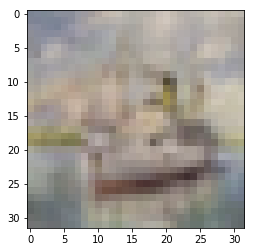

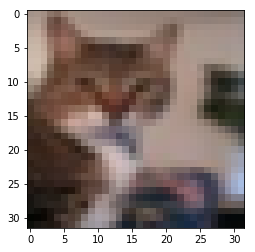

predicted ship
true ship
****************************************************************************************************


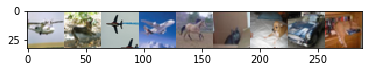

tensor([1.3916e-01, 2.7836e-02, 6.9732e-03, 2.8042e-03, 8.0476e-01, 1.2243e-02,
        4.6303e-03, 5.0997e-04, 1.0825e-03], dtype=torch.float64)


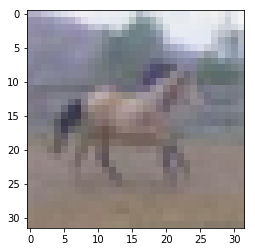

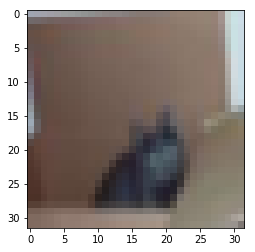

predicted horse
true horse
****************************************************************************************************


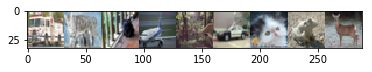

tensor([0.8055, 0.0702, 0.0019, 0.0233, 0.0117, 0.0333, 0.0352, 0.0099, 0.0089],
       dtype=torch.float64)


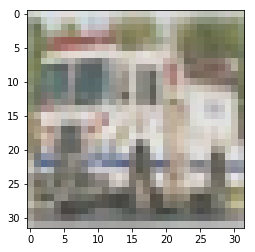

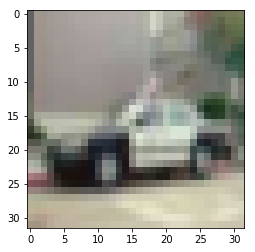

predicted truck
true truck
****************************************************************************************************


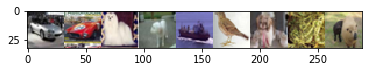

tensor([8.8669e-03, 1.0531e-03, 1.9397e-02, 7.4372e-02, 8.9032e-01, 1.8204e-04,
        2.3070e-03, 7.8486e-05, 3.4221e-03], dtype=torch.float64)


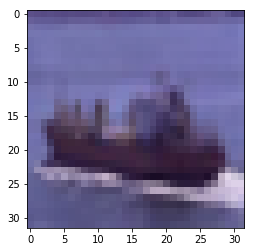

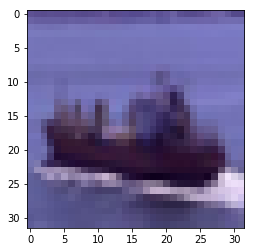

predicted ship
true ship
****************************************************************************************************


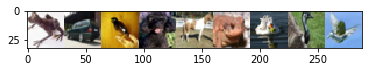

tensor([2.1579e-04, 2.5928e-03, 5.6968e-04, 6.6684e-03, 9.1948e-01, 6.7849e-03,
        6.1254e-02, 8.9294e-04, 1.5378e-03], dtype=torch.float64)


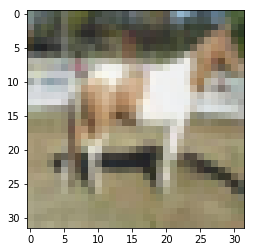

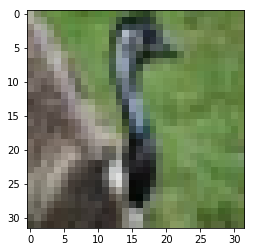

predicted horse
true horse
****************************************************************************************************


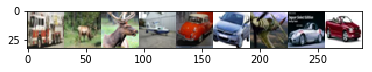

tensor([9.9202e-01, 3.2329e-03, 1.3566e-04, 6.5703e-04, 5.5412e-05, 1.8623e-05,
        2.7977e-03, 1.0567e-03, 2.1399e-05], dtype=torch.float64)


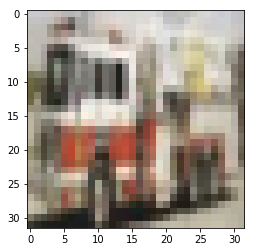

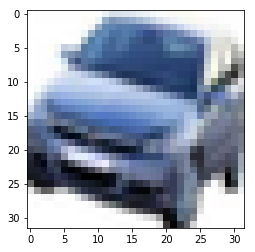

predicted truck
true truck
****************************************************************************************************


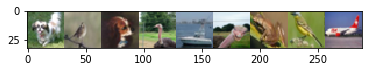

tensor([5.3434e-03, 4.1257e-03, 6.7887e-03, 1.1735e-02, 9.2027e-01, 2.6898e-03,
        1.5587e-02, 6.7317e-04, 3.2784e-02], dtype=torch.float64)


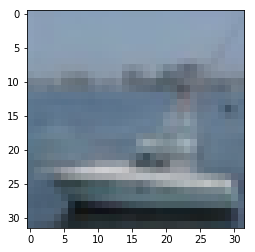

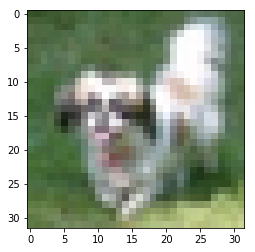

predicted ship
true ship
****************************************************************************************************


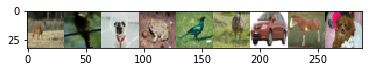

tensor([0.0615, 0.0229, 0.0215, 0.0021, 0.0072, 0.0147, 0.0626, 0.7948, 0.0126],
       dtype=torch.float64)


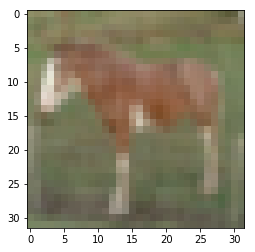

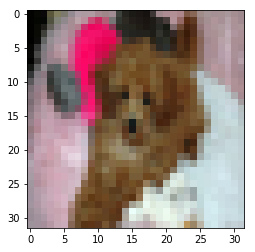

predicted horse
true horse
****************************************************************************************************


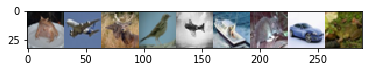

tensor([2.1912e-04, 9.9448e-04, 1.8793e-04, 3.2601e-05, 1.4604e-04, 9.9749e-01,
        2.8903e-04, 5.8914e-04, 5.4233e-05], dtype=torch.float64)


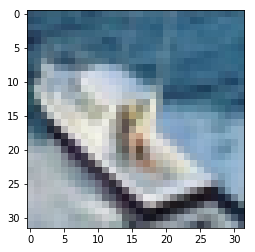

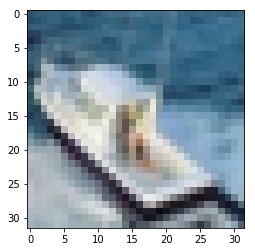

predicted ship
true ship
****************************************************************************************************


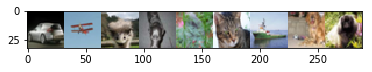

tensor([2.1897e-03, 9.4587e-04, 2.7354e-03, 2.9037e-03, 3.3910e-03, 1.1615e-02,
        9.7337e-01, 1.9846e-03, 8.6817e-04], dtype=torch.float64)


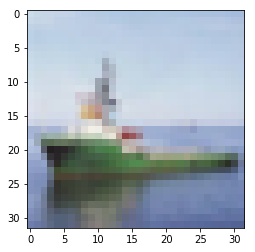

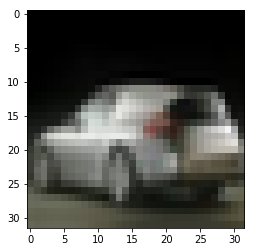

predicted ship
true ship
****************************************************************************************************


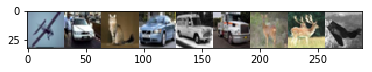

tensor([6.5764e-05, 2.7959e-02, 5.9940e-04, 7.3612e-05, 9.4682e-04, 9.6835e-01,
        4.2120e-04, 7.7061e-05, 1.5054e-03], dtype=torch.float64)


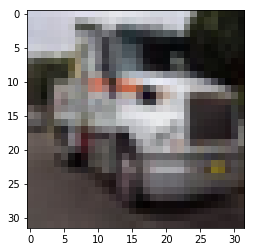

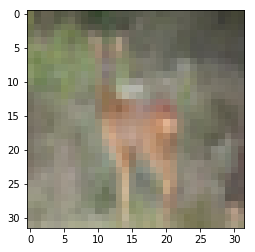

predicted truck
true truck
****************************************************************************************************


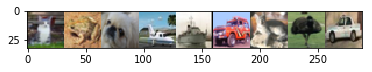

tensor([3.5771e-02, 1.9409e-04, 5.1110e-03, 5.3012e-01, 4.0551e-01, 5.4870e-03,
        6.1813e-03, 6.9012e-03, 4.7289e-03], dtype=torch.float64)


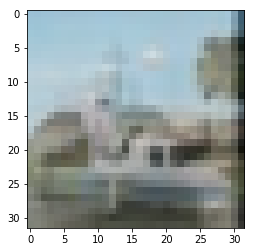

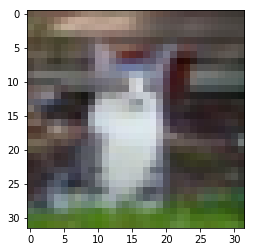

predicted ship
true ship
****************************************************************************************************


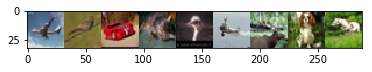

tensor([0.0011, 0.0377, 0.0080, 0.0341, 0.0425, 0.0319, 0.0775, 0.0144, 0.7529],
       dtype=torch.float64)


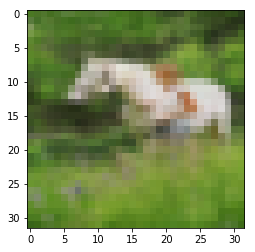

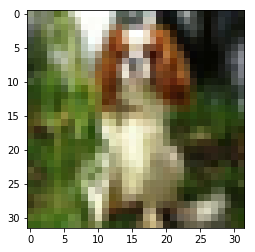

predicted horse
true horse
****************************************************************************************************


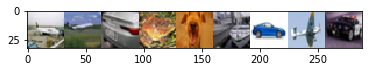

tensor([0.0372, 0.0757, 0.0884, 0.0056, 0.0446, 0.1931, 0.0706, 0.0653, 0.4196],
       dtype=torch.float64)


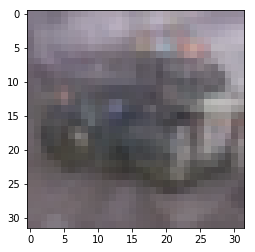

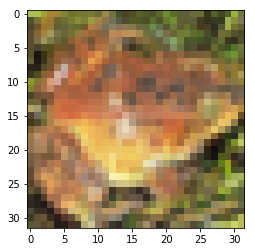

predicted truck
true ship
****************************************************************************************************


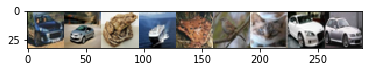

tensor([4.3100e-04, 2.6414e-05, 4.2463e-04, 9.9705e-01, 8.1646e-05, 1.9815e-05,
        1.8272e-03, 1.0101e-04, 3.4510e-05], dtype=torch.float64)


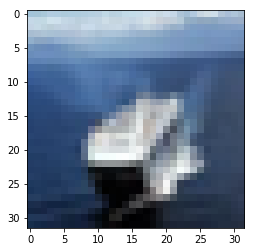

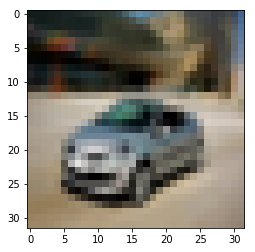

predicted ship
true ship
****************************************************************************************************


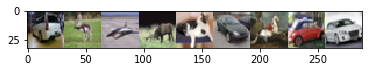

tensor([0.6527, 0.0085, 0.0099, 0.1381, 0.0179, 0.0025, 0.0937, 0.0651, 0.0116],
       dtype=torch.float64)


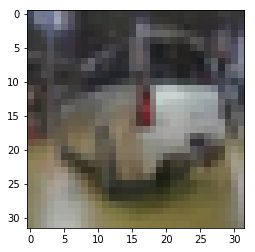

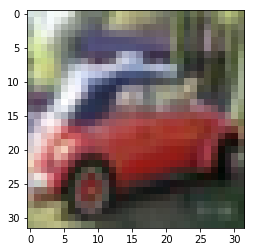

predicted horse
true horse
****************************************************************************************************


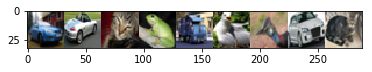

tensor([7.8691e-02, 7.7040e-04, 9.2461e-03, 2.9489e-04, 8.7657e-01, 2.6114e-02,
        3.0117e-03, 3.9133e-03, 1.3851e-03], dtype=torch.float64)


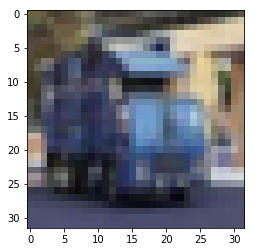

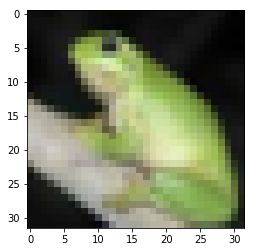

predicted truck
true truck
****************************************************************************************************


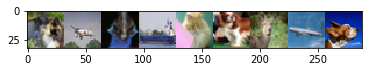

tensor([1.9990e-03, 6.9611e-04, 3.3903e-03, 9.1268e-01, 2.6177e-03, 1.2538e-02,
        9.1166e-03, 6.1657e-03, 5.0800e-02], dtype=torch.float64)


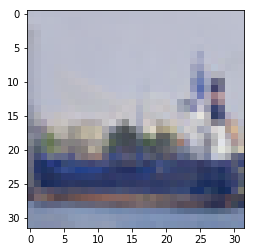

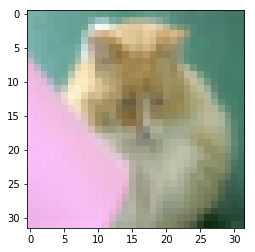

predicted ship
true ship
****************************************************************************************************


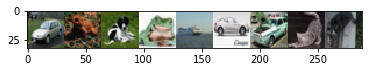

tensor([0.1056, 0.0595, 0.0284, 0.1328, 0.4667, 0.0094, 0.1564, 0.0188, 0.0224],
       dtype=torch.float64)


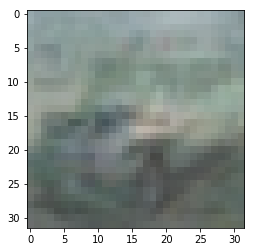

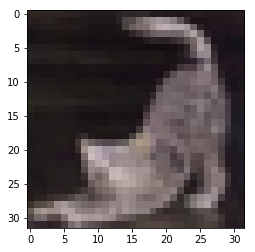

predicted ship
true ship
****************************************************************************************************


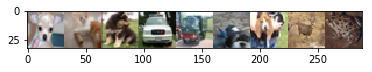

tensor([1.7070e-04, 5.3387e-04, 7.1701e-04, 2.3854e-05, 9.9749e-01, 1.6612e-04,
        6.6726e-04, 1.3417e-04, 9.4178e-05], dtype=torch.float64)


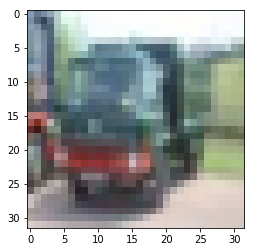

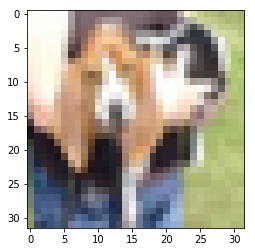

predicted truck
true truck
****************************************************************************************************


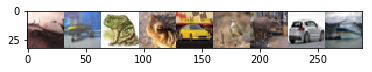

tensor([1.3381e-03, 1.0052e-01, 3.5282e-03, 1.9576e-02, 7.3592e-04, 5.4559e-03,
        2.2104e-02, 4.5142e-03, 8.4223e-01], dtype=torch.float64)


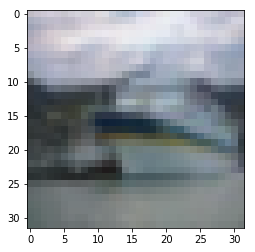

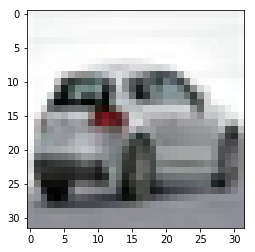

predicted ship
true ship
****************************************************************************************************


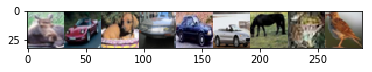

tensor([0.1621, 0.0057, 0.0170, 0.1017, 0.0377, 0.0232, 0.6413, 0.0051, 0.0063],
       dtype=torch.float64)


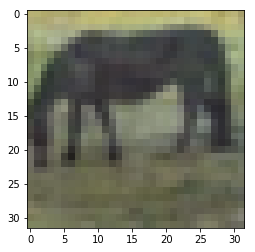

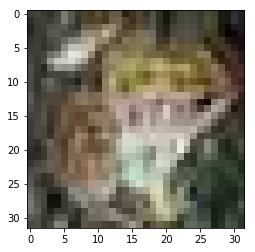

predicted horse
true horse
****************************************************************************************************


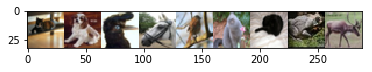

tensor([0.2686, 0.0064, 0.3577, 0.1111, 0.0849, 0.0513, 0.0127, 0.0624, 0.0450],
       dtype=torch.float64)


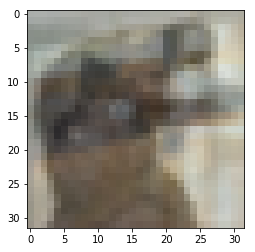

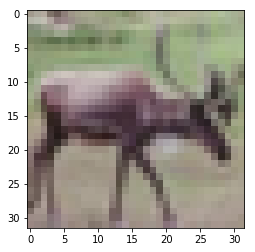

predicted horse
true horse
****************************************************************************************************


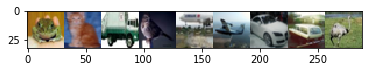

tensor([0.0009, 0.0023, 0.8138, 0.0023, 0.0173, 0.0835, 0.0114, 0.0616, 0.0070],
       dtype=torch.float64)


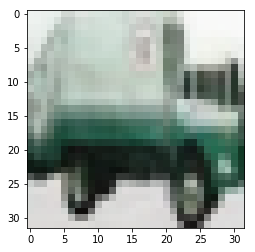

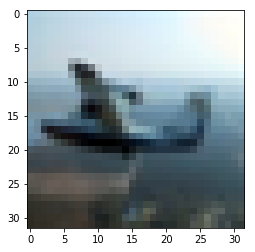

predicted truck
true truck
****************************************************************************************************


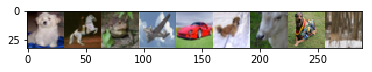

tensor([3.2026e-03, 8.3860e-01, 3.0506e-02, 1.4461e-02, 6.1470e-04, 1.0773e-02,
        3.2233e-02, 5.0245e-02, 1.9363e-02], dtype=torch.float64)


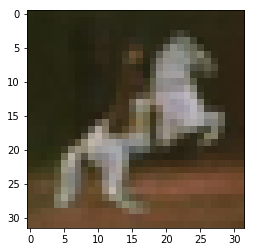

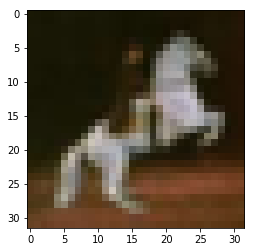

predicted horse
true horse
****************************************************************************************************


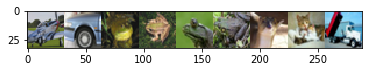

tensor([2.4598e-02, 1.6859e-03, 2.4911e-04, 6.5084e-05, 1.2994e-03, 2.9806e-04,
        8.3101e-03, 5.5828e-02, 9.0767e-01], dtype=torch.float64)


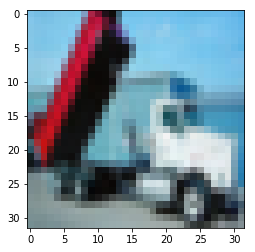

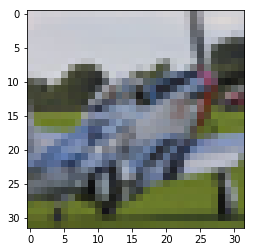

predicted truck
true truck
****************************************************************************************************


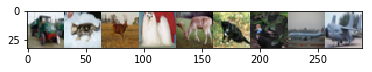

tensor([8.7223e-01, 8.8847e-05, 1.6035e-03, 3.6363e-04, 5.1514e-03, 5.1394e-04,
        6.3602e-04, 1.1933e-01, 8.8091e-05], dtype=torch.float64)


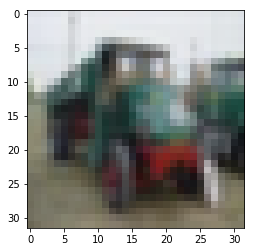

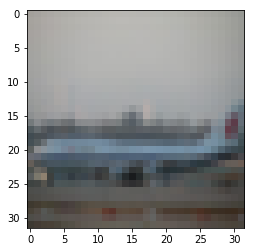

predicted truck
true truck
****************************************************************************************************


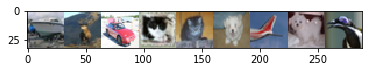

tensor([6.9204e-01, 3.9175e-02, 2.7847e-02, 4.4679e-04, 2.0519e-03, 1.2136e-02,
        1.5407e-01, 6.6524e-02, 5.7177e-03], dtype=torch.float64)


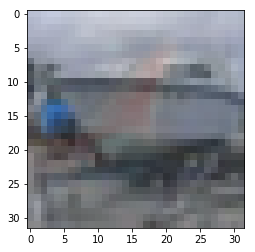

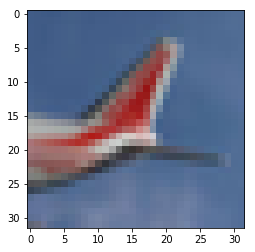

predicted ship
true ship
****************************************************************************************************


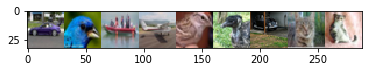

tensor([4.1302e-04, 1.5436e-04, 9.9496e-01, 3.1750e-03, 4.3586e-05, 1.3357e-04,
        3.6801e-04, 1.8452e-04, 5.7233e-04], dtype=torch.float64)


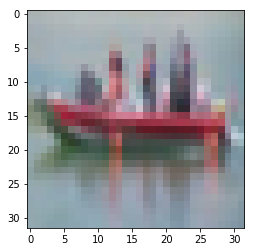

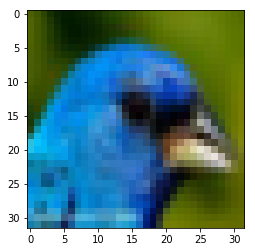

predicted ship
true ship
****************************************************************************************************


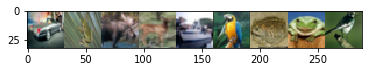

tensor([1.8240e-03, 7.5851e-04, 1.1262e-03, 3.8815e-04, 9.9318e-01, 4.0089e-04,
        4.8783e-04, 1.5894e-03, 2.4368e-04], dtype=torch.float64)


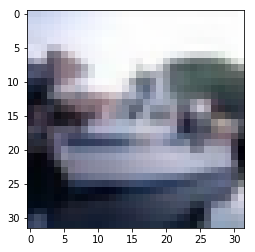

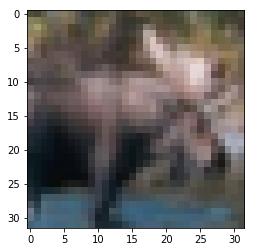

predicted ship
true ship
****************************************************************************************************


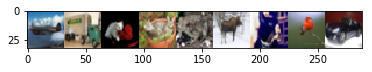

tensor([5.1312e-04, 9.7198e-01, 1.0835e-03, 1.0890e-04, 1.8745e-04, 5.3627e-03,
        1.2173e-02, 5.0130e-03, 3.5793e-03], dtype=torch.float64)


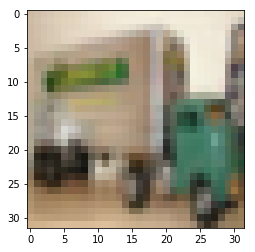

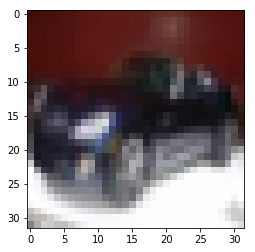

predicted truck
true truck
****************************************************************************************************


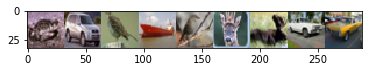

tensor([0.0831, 0.0180, 0.0062, 0.7760, 0.0047, 0.0710, 0.0145, 0.0222, 0.0043],
       dtype=torch.float64)


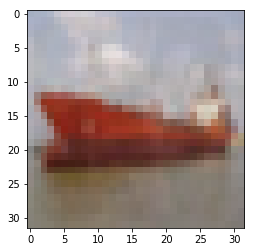

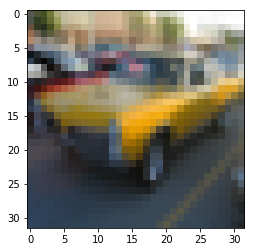

predicted ship
true ship
****************************************************************************************************


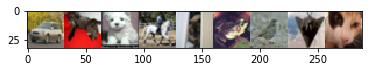

tensor([0.0071, 0.3687, 0.0480, 0.2461, 0.0424, 0.1091, 0.0969, 0.0289, 0.0529],
       dtype=torch.float64)


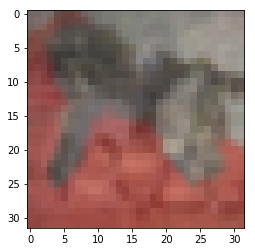

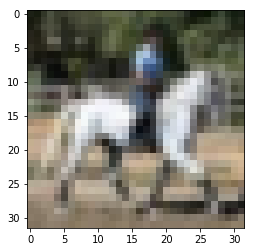

predicted horse
true horse
****************************************************************************************************


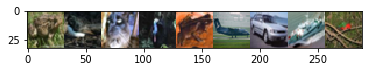

tensor([0.0483, 0.0971, 0.0079, 0.0094, 0.0455, 0.0489, 0.0473, 0.6806, 0.0150],
       dtype=torch.float64)


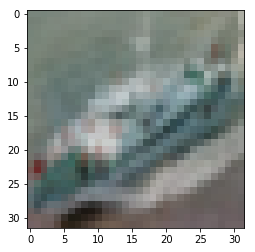

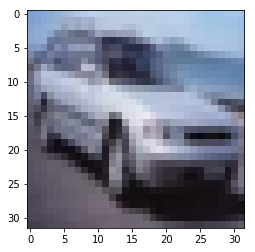

predicted ship
true ship
****************************************************************************************************


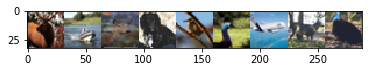

tensor([1.5285e-02, 7.3857e-01, 2.9378e-02, 2.1770e-02, 4.9530e-02, 8.1940e-03,
        1.8695e-04, 1.3556e-01, 1.5247e-03], dtype=torch.float64)


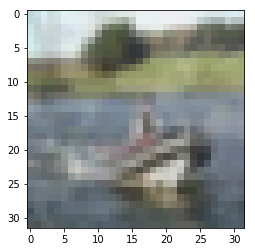

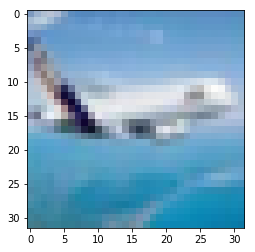

predicted ship
true ship
****************************************************************************************************


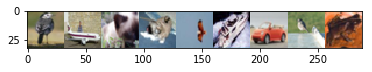

tensor([0.0869, 0.1744, 0.1825, 0.0893, 0.0134, 0.0103, 0.3532, 0.0074, 0.0825],
       dtype=torch.float64)


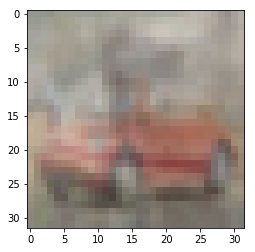

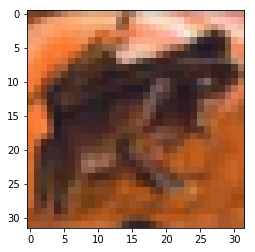

predicted ship
true ship
****************************************************************************************************


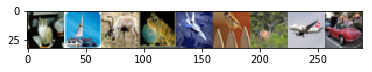

tensor([2.0025e-02, 5.9290e-01, 2.2327e-02, 1.0276e-04, 4.6754e-02, 1.1957e-01,
        1.5356e-01, 5.5642e-04, 4.4213e-02], dtype=torch.float64)


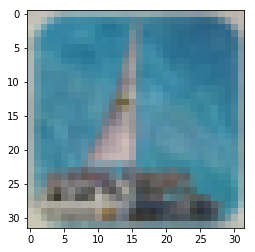

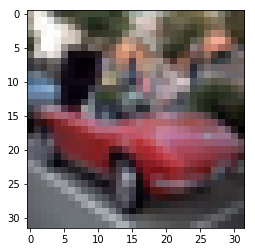

predicted ship
true ship
****************************************************************************************************


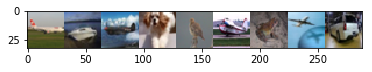

tensor([2.2446e-03, 8.0432e-01, 3.8929e-03, 2.8059e-04, 4.0961e-03, 2.4321e-03,
        2.2858e-02, 2.1824e-03, 1.5769e-01], dtype=torch.float64)


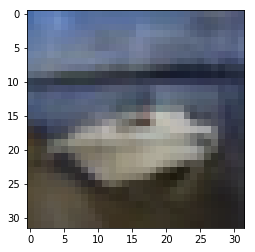

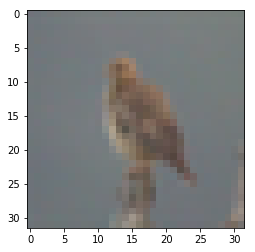

predicted ship
true ship
****************************************************************************************************


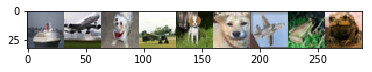

tensor([9.9013e-01, 1.5135e-04, 1.9253e-03, 4.7556e-04, 4.3422e-05, 1.0666e-04,
        4.8158e-04, 5.3348e-05, 6.6350e-03], dtype=torch.float64)


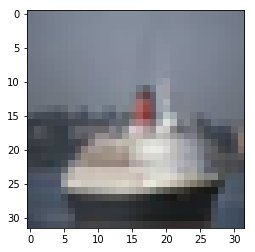

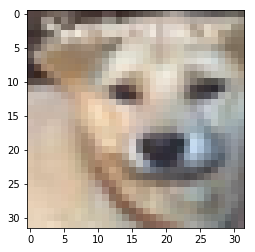

predicted ship
true ship
****************************************************************************************************


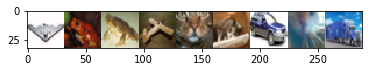

tensor([0.0768, 0.2221, 0.0014, 0.0602, 0.0279, 0.0057, 0.0009, 0.0818, 0.5233],
       dtype=torch.float64)


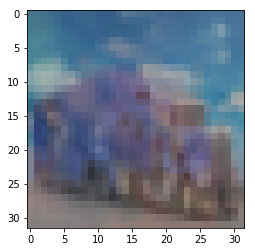

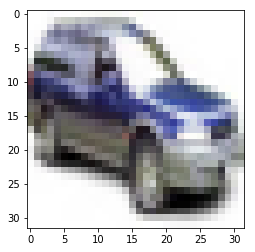

predicted truck
true truck
****************************************************************************************************


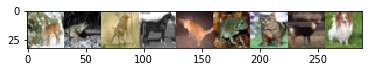

tensor([7.0572e-03, 9.2923e-04, 8.6352e-04, 9.8410e-01, 5.7641e-05, 1.5484e-03,
        4.4300e-03, 5.7213e-04, 4.3884e-04], dtype=torch.float64)


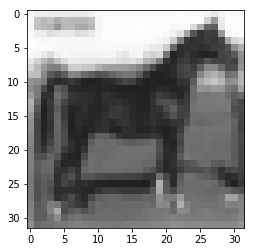

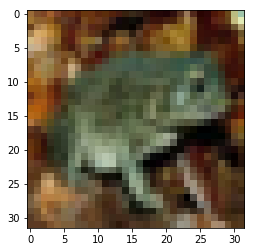

predicted horse
true horse
****************************************************************************************************


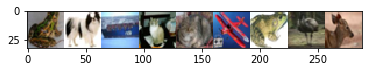

tensor([0.1195, 0.1031, 0.2114, 0.0617, 0.0370, 0.1881, 0.0614, 0.1478, 0.0699],
       dtype=torch.float64)


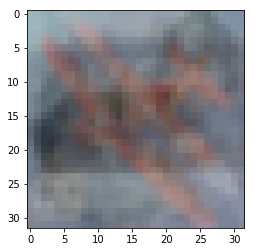

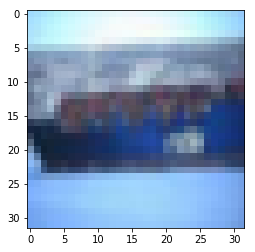

predicted ship
true ship
****************************************************************************************************


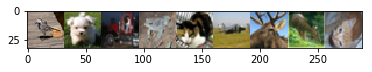

tensor([0.0046, 0.0016, 0.9715, 0.0032, 0.0026, 0.0051, 0.0067, 0.0037, 0.0010],
       dtype=torch.float64)


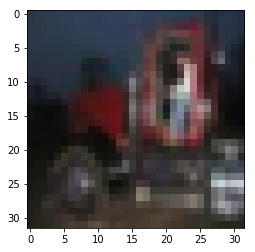

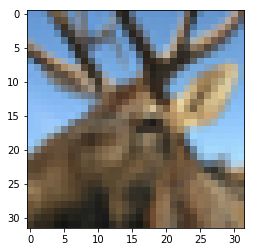

predicted truck
true truck
****************************************************************************************************


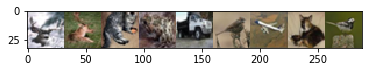

tensor([3.9592e-04, 4.7428e-04, 4.3883e-03, 1.5753e-03, 9.8523e-01, 9.3431e-04,
        3.3304e-04, 1.6099e-03, 5.0563e-03], dtype=torch.float64)


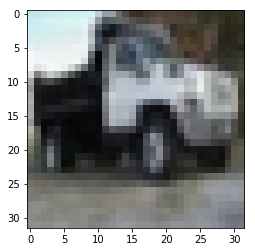

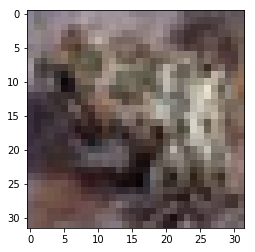

predicted truck
true truck
Accuracy of the network on the 10000 test images: 87 %
total correct 8707
total test set images 10000


In [31]:
correct = 0
total = 0
flag =1
with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    outputs, alphas, avg_images = fore_net(inputs)
    _, predicted = torch.max(outputs.data, 1)


    if flag==1 :
      for j in range (50):
        print("*"*100)
        img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
        display(img1)

        print(alphas[j])

        img2 = avg_images[j]
        display(img2)

        img3 = inputs[j][fore_idx_test[j]]
        display(img3)

        print("predicted", classes[predicted[j]+7])
        print("true", classes[labels[j]+7])

      flag =0


    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
print("total correct", correct)
print("total test set images", total)

In [0]:
a = torch.tensor([0.0071, 0.0466, 0.0025, 0.0282, 0.0140, 0.0067, 0.0145, 0.8750, 0.0055])

In [33]:
print(torch.argmax(a) == 7)
print(batch)

tensor(True)
250


In [34]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

train_loader1 = DataLoader( msd,batch_size= batch ,shuffle=False)
with torch.no_grad():
  for data in train_loader1:
    inputs, labels , fore_idx = data
    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1
      
#       print("*"*100)
#       img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
#       display(img1)

#       print(alphas[j])

#       img2 = avg_images[j]
#       display(img2)

#       img3 = inputs[j][fore_idx[j]]
#       display(img3)

#       print("predicted", classes[predicted[j]+7])
#       print("true", classes[labels[j]+7])

     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

Accuracy of the network on the 30000 train images: 98 %
total correct 29600
total train set images 30000
focus_true_pred_true 25883
focus_false_pred_true 3717
focus_true_pred_false 132
focus_false_pred_false 268
argmax_more_than_half 26778
argmax_less_than_half 3222


In [35]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    outputs, alphas, avg_images = fore_net(inputs)

    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1
      
#       print("*"*100)
#       img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
#       display(img1)

#       print(alphas[j])

#       img2 = avg_images[j]
#       display(img2)

#       img3 = inputs[j][fore_idx[j]]
#       display(img3)

#       print("predicted", classes[predicted[j]+7])
#       print("true", classes[labels[j]+7])

     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

Accuracy of the network on the 30000 train images: 87 %
total correct 8707
total train set images 10000
focus_true_pred_true 7826
focus_false_pred_true 881
focus_true_pred_false 326
focus_false_pred_false 967
argmax_more_than_half 8441
argmax_less_than_half 1559
